In [362]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [363]:
df = pd.read_csv("features/ff_pol.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl', 'CuI', 'LiF',
       'ZnS'], dtype=object)

### Size Modification and adding parameters to Data Frame

In [364]:
df

,Mol,Pol_C,Pol_A,CN_C,Ion_C,Ion_A,EA_A,EN_C,EN_A
0,LiH,164.10,4.51,6,5.392,13.590,0.754,0.98,2.20
1,NaH,162.70,4.51,6,5.139,13.590,0.754,0.93,2.20
2,KH,289.70,4.51,6,4.341,13.590,0.754,0.82,2.20
3,RbH,319.80,4.51,6,4.177,13.590,0.754,0.82,2.20
4,CsH,400.60,4.51,6,3.849,13.590,0.754,0.79,2.20
5,CsCl,400.60,14.60,8,3.849,12.960,3.617,0.79,3.16
6,LiCl,164.10,14.60,6,5.392,12.960,3.617,2.20,3.16
7,CuI,46.50,32.90,4,7.726,10.451,3.059,1.90,2.66
8,LiF,164.10,3.74,6,5.392,17.423,3.339,2.20,3.98
9,ZnS,38.67,19.40,4,9.394,10.360,2.077,1.65,2.58


In [365]:

%store -r res
res

[14.13330815446956,
 14.081369567351956,
 14.034265054162475,
 12.926169405830962,
 12.27212198878638,
 3.230739472566894,
 5.121300394981286,
 3.5739198265668453,
 4.715887333726234,
 2.499975609761724]

In [366]:
# drip first and 2nd row
# df = df.drop(index=[0,2], axis=1)
# res = res[1:2] + res[3:]
df

,Mol,Pol_C,Pol_A,CN_C,Ion_C,Ion_A,EA_A,EN_C,EN_A
0,LiH,164.10,4.51,6,5.392,13.590,0.754,0.98,2.20
1,NaH,162.70,4.51,6,5.139,13.590,0.754,0.93,2.20
2,KH,289.70,4.51,6,4.341,13.590,0.754,0.82,2.20
3,RbH,319.80,4.51,6,4.177,13.590,0.754,0.82,2.20
4,CsH,400.60,4.51,6,3.849,13.590,0.754,0.79,2.20
5,CsCl,400.60,14.60,8,3.849,12.960,3.617,0.79,3.16
6,LiCl,164.10,14.60,6,5.392,12.960,3.617,2.20,3.16
7,CuI,46.50,32.90,4,7.726,10.451,3.059,1.90,2.66
8,LiF,164.10,3.74,6,5.392,17.423,3.339,2.20,3.98
9,ZnS,38.67,19.40,4,9.394,10.360,2.077,1.65,2.58


In [367]:
# always inverse of EN_A
# val = df['EA_A']
# df['comb'] = 1/ df['EA_A']
# # df['comb'] = df['comb'] * df['Ion_C']
# df['comb'] = df['comb'] * df['CN_C']
# df['comb'] = df['comb'] * df['EN_C']
# df['comb'] = df['comb'] / df['Pol_A']

## always inverse of delta EN

## always inverse of pol_A ( anion polarisation)

## remove df['EA_A'] from the dataframe
df = df.drop(columns=['EA_A'])
# df = df.drop(columns=['Ion_C'])
df = df.drop(columns=['CN_C'])
df = df.drop(columns=['Pol_A'])
df = df.drop(columns=['Pol_C'])
# df = df.drop(columns=['EN_C'])

# df = df.drop(columns=['Pol_A'])

res

[14.13330815446956,
 14.081369567351956,
 14.034265054162475,
 12.926169405830962,
 12.27212198878638,
 3.230739472566894,
 5.121300394981286,
 3.5739198265668453,
 4.715887333726234,
 2.499975609761724]

In [368]:
# df = df.iloc[:10,0:]


## always inverse of EN_A

# df['Sum_EN'] = df['EN_C'] + df['EN_A']
# df['Diff_EN'] = abs(df['EN_A'] - df['EN_C'])
# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']


df['Sum_ion'] = df['Ion_C'] + df['Ion_A']
df['Sum_ion'] = df['Sum_ion']*df['Sum_ion']*df['Sum_ion']

df['Abs_diff_ion'] = abs(df['Ion_C'] - df['Ion_A'])
df['Abs_diff_ion'] = df['Abs_diff_ion']*df['Abs_diff_ion']*df['Abs_diff_ion']

df['Sum_EN'] = df['EN_A'] + df['EN_C']
df['Sum_EN'] = df['Sum_EN']*df['Sum_EN']*df['Sum_EN']

df['Abs_diff_EN'] = abs(df['EN_A'] - df['EN_C'])
df['Abs_diff_EN'] = df['Abs_diff_EN']*df['Abs_diff_EN']*df['Abs_diff_EN']
# df['Abs_diff_pol'] = abs(df['Pol_C'] - df['Pol_A'])




# Adding sqrt values for each column
# for col in df.columns:
#     # Make sure the column is numeric before applying sqrt
#     if pd.api.types.is_numeric_dtype(df[col]):
#         # df[f'{col}_sqrt'] = np.sqrt(abs(df[col]))
#         # df[f'{col}_squared'] = np.square(df[col])
#         df.drop(columns=[col], inplace=True)

# df = df.drop(columns=['EN_C'])

# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']
# df['diff_pol'] = abs(df['Pol_C'] - df['Pol_A'])

# df = df[['Ion_C','Abs_diff_ion','Sum_pol','Abs_diff_pol','CN_C']]

df.shape

(10, 9)

In [369]:
df

,Mol,Ion_C,Ion_A,EN_C,EN_A,Sum_ion,Abs_diff_ion,Sum_EN,Abs_diff_EN
0,LiH,5.392,13.590,0.98,2.20,6839.524462,550.964658,32.157432,1.815848
1,NaH,5.139,13.590,0.93,2.20,6569.673234,603.565358,30.664297,2.048383
2,KH,4.341,13.590,0.82,2.20,5765.188765,791.196465,27.543608,2.628072
3,RbH,4.177,13.590,0.82,2.20,5608.442957,834.034808,27.543608,2.628072
4,CsH,3.849,13.590,0.79,2.20,5303.526376,924.295056,26.730899,2.803221
5,CsCl,3.849,12.960,0.79,3.16,4749.256563,756.307035,61.629875,13.312053
6,LiCl,5.392,12.960,2.20,3.16,6180.878430,433.454354,153.990656,0.884736
7,CuI,7.726,10.451,1.90,2.66,6005.741311,20.234828,94.818816,0.438976
8,LiF,5.392,17.423,2.20,3.98,11875.760193,1741.426626,236.029032,5.639752
9,ZnS,9.394,10.360,1.65,2.58,7708.416073,0.901429,75.686967,0.804357


### making the combinations

In [370]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [371]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [372]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


In [373]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:,].columns)
    all_expressions = generate_combinations_df(df.iloc[:,], param_names)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_5316\3972913922.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(19682, 2)


In [374]:
expressions['Value'] = expressions['Value'] 
expressions.head()

,Expression,Value
0,Mol,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5...
1,Ion_C,0 5.392 1 5.139 2 4.341 3 4.177 4 ...
2,Ion_A,0 13.590 1 13.590 2 13.590 3 13.59...
3,EN_C,0 0.98 1 0.93 2 0.82 3 0.82 4 0...
4,EN_A,0 2.20 1 2.20 2 2.20 3 2.20 4 2...


### Addition results to the combinations

In [375]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [376]:

correlation = values.corr()

correlation.shape

(19683, 19683)

In [377]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                                     1.000000
Ion_C * EN_A * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)         0.996999
Ion_C * EN_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                      0.996967
Ion_C * Ion_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                     0.995789
Ion_C * Ion_A * EN_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)              0.995525
Ion_C * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                             0.995517
Ion_C * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                0.994980
Ion_C * Ion_A * Abs_diff_ion * EN_A^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                               0.994129
Ion_C * Ion_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * EN_A^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1) 

### Final Results

In [378]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index


res                                                                                                     1.000000
Ion_C * EN_A * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)         0.996999
Ion_C * EN_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                      0.996967
Ion_C * Ion_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                     0.995789
Ion_C * Ion_A * EN_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)              0.995525
Ion_C * Sum_ion * Abs_diff_ion * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                             0.995517
Ion_C * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                0.994980
Ion_C * Ion_A * Abs_diff_ion * EN_A^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1)                               0.994129
Ion_C * Ion_A * Sum_ion * Abs_diff_ion * EN_C^(-1) * EN_A^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1) 

In [379]:
# import matplotlib.pyplot as plt

# plt.scatter(results['res'],results[top_vars[3]])
# plt.plot(results['res'],results[top_vars[0]])
# plt.show()

# values[top_vars[0]]


# # param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']



# # y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
# # x = list(values['res'])[:4]+list(values['res'])[5:]

# # plt.scatter(x,y)
# # x

# print(results['res'])

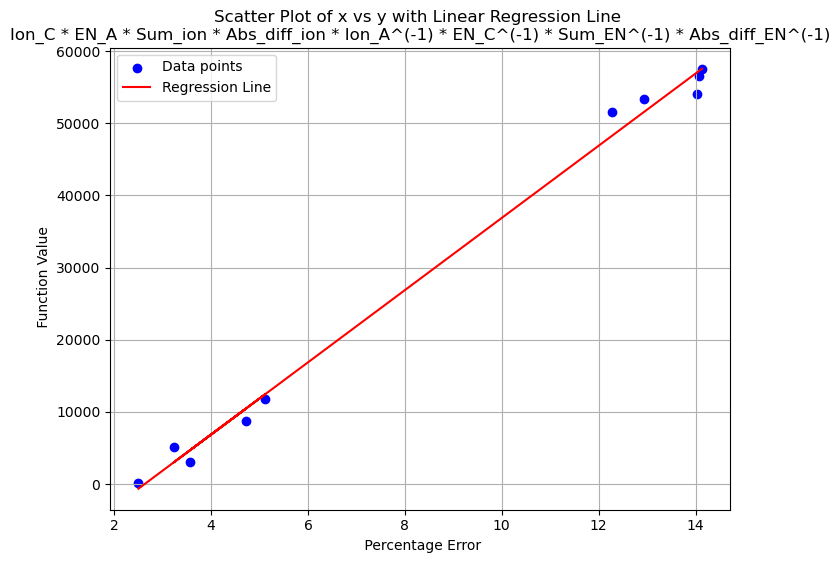

(0.9940067018367911, 3632152.19411378, 'y = 5001.1759x + -13137.4522')

In [380]:
param = top_vars[0]

y = values[param]
x = values['res']

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming x and y are Pandas Series
# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Plot the data points and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line \n{param}')
plt.xlabel(' Percentage Error')
plt.ylabel(' Function Value')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSE
r_squared = r2_score(y, y_pred)
msd = mean_squared_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared, msd, equation


### Results

1. Ion_C * EN_A * Sum_ion * Abs_diff_ion * Ion_A^(-1) * EN_C^(-1) * Sum_EN^(-1) * Abs_diff_EN^(-1) 